# 02 - Training

## A - Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np

from metaboDGD.util import data, train
from metaboDGD.src import model
import matplotlib.pyplot as plt
import torch
import seaborn as sns
plt.rcParams["font.family"] = 'Arial'

## B - Retrieve Dataframe and Cohorts

In [2]:
dir = 'outputs/'
df_fname = 'CombinedDataset_CAMP_Normal.csv'
df_tumor_fname = 'CombinedDataset_CAMP_Tumor.csv'
cohorts_fname = 'cohorts_Normal.pkl'
cohorts_tumor_fname = 'cohorts_Tumor.pkl'

In [3]:
df = pd.read_csv(dir + df_fname)
df.set_index('Unnamed: 0', inplace=True)
df.index.name = None
df_lbls = df.loc['cohort'].to_list()
df_log = df.T.drop(columns=['cohort']).astype('float64')

df_tumor = pd.read_csv(dir + df_tumor_fname)
df_tumor.set_index('Unnamed: 0', inplace=True)
df_tumor.index.name = None
df_tumor_lbls = df_tumor.loc['cohort'].to_list()
df_tumor_log = df_tumor.T.drop(columns=['cohort']).astype('float64')


# df_exp = pd.read_csv(dir + df_exp_fname)
# df_exp.set_index('Unnamed: 0', inplace=True)
# df_exp.index.name = None


f = open(dir + cohorts_fname, 'rb')
cohorts = pickle.load(f)
f.close()

ft = open(dir + cohorts_tumor_fname, 'rb')
cohorts_tumor = pickle.load(ft)

In [4]:
# pca_fit[0:47,0]   ,  BRCA1
# pca_fit[47:94,0]  ,  ccRCC
# pca_fit[94:118,0] ,  ccRCC
# pca_fit[118:157,0],  COAD
# pca_fit[157:163,0],  GBM
# pca_fit[163:166,0],  HurthleCC
# pca_fit[166:178,0],  PDAC
# pca_fit[178:224,0],  PRAD

# ind_pos = [x for x in range(0,118)] + [x for x in range(157,178)]
# plt.hist(df_log['alanine'].to_numpy()[ind_pos], bins=50)
# plt.show()

## C - Initializing DataLoaders and the DGD Model

In [5]:
train_dict = {}
test_dict  = {}

train_lbls = []
test_lbls  = []

In [6]:
train_loader, test_loader = data.create_dataloaders(
    cohorts=cohorts,
    df=df_log,
    batch_size=32
)

In [14]:
dgd_model = model.MetaboDGD(
    latent_dim=20,
    output_dim=df_log.shape[1],
    dec_hidden_layers_dim=[500, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=6,
    cm_type='diagonal',
    gaussian_stddev=0.5
)

## D - Training the DGD Model

In [ ]:
dgd_model, train_rep, test_rep, history, cm = train.train_dgd(
    dgd_model=dgd_model,
    train_loader=train_loader,
    validation_loader=test_loader,
    n_epochs=250,
    lr_schedule_epochs=None,
    lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
    optim_betas=[0.5, 0.7],
    wd=1e-5,
)

train.get_history_plot(history, inc_gmm_acc=True)

In [ ]:
torch.load('98_85_acc/torch_outputs_dec.pt')

In [7]:
dgd_final = model.MetaboDGD(
    latent_dim=20,
    output_dim=df_log.shape[1],
    dec_hidden_layers_dim=[500, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=8,
    cm_type='diagonal',
    gaussian_stddev=0.5
)

# dgd_final.dec.load_state_dict(torch.load('torch_outputs/torch_outputs_dec.pt'))
# dgd_final.gmm.load_state_dict(torch.load('torch_outputs/torch_outputs_gmm.pt'))
dgd_final.dec.load_state_dict(torch.load('98_85_acc/torch_outputs_dec.pt'))
dgd_final.gmm.load_state_dict(torch.load('98_85_acc/torch_outputs_gmm.pt'))

RuntimeError: Error(s) in loading state_dict for Decoder:
	Unexpected key(s) in state_dict: "nn.1.weight", "nn.3.weight". 

In [8]:
from metaboDGD.src.latent import RepresentationLayer
train_rep_final = RepresentationLayer(values=torch.zeros(size=(len(train_loader.dataset), dgd_final.gmm.dim)))
# train_rep_final.load_state_dict(torch.load('torch_outputs/torch_outputs_train_rep.pt'))
train_rep_final.load_state_dict(torch.load('98_85_acc/torch_outputs_train_rep.pt'))

<All keys matched successfully>

In [ ]:
tumor_rep_final, dec_out_final = dgd_final.get_representations(df_tumor_log, df_tumor_lbls, df_tumor_log.shape[0])

## F - Training Results

### The History Table

In [ ]:
history

,train_loss,val_loss,train_recon_loss,val_recon_loss,train_dist_loss,val_dist_loss,cluster_acc,epoch
0,10.027155,9.891689,9.209253,9.149130,74.756316,67.869947,0.342593,1
1,9.907102,9.779315,9.197715,9.134773,64.837956,58.911095,0.342593,2
2,9.797038,9.673914,9.181466,9.115042,56.263257,51.080844,0.342593,3
3,9.693166,9.573477,9.159656,9.089607,48.762739,44.225753,0.342593,4
4,9.593713,9.476908,9.132038,9.058670,42.197107,38.226871,0.342593,5
...,...,...,...,...,...,...,...,...
245,2.741956,2.791810,2.695007,2.744847,4.291089,4.292421,0.759259,246
246,2.738974,2.787789,2.692017,2.740863,4.291875,4.289051,0.666667,247
247,2.736075,2.784083,2.689109,2.737095,4.292735,4.294742,0.814815,248
248,2.733400,2.780509,2.686413,2.733562,4.294627,4.290992,0.703704,249


### Figure X. Matrix

In [ ]:
def get_aic(dgd, history):
    k = num_parameeters = sum(p.numel() for p in dgd.dec.parameters() if p.requires_grad) + sum(p.numel() for p in dgd.gmm.parameters() if p.requires_grad)
    return 2 * k + 2 * history.iloc[-1]['train_loss']

get_aic(dgd_model, history)

np.float64(7015813.46157016)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

le = LabelEncoder()
true_labels = le.fit_transform(train_loader.dataset.get_labels())
clustering  = torch.exp(dgd_model.gmm.get_log_prob_comp(train_rep.z.detach()))
pred_labels = torch.max(clustering, dim=-1).indices.cpu().detach().numpy()
cm_test = confusion_matrix(true_labels, pred_labels)
cm_test

idxs = linear_sum_assignment(-cm_test + np.max(cm_test))
cm_test2 = cm_test[:, idxs[1]]
# print(true_labels)
# print(pred_labels)

# print(cm_test)

# adjusted_rand_score(true_labels, pred_labels)

C:\Users\Alfonso Miguel Cruz\AppData\Local\Temp\ipykernel_37952\3266129158.py:1: RuntimeWarning: invalid value encountered in divide
  cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)


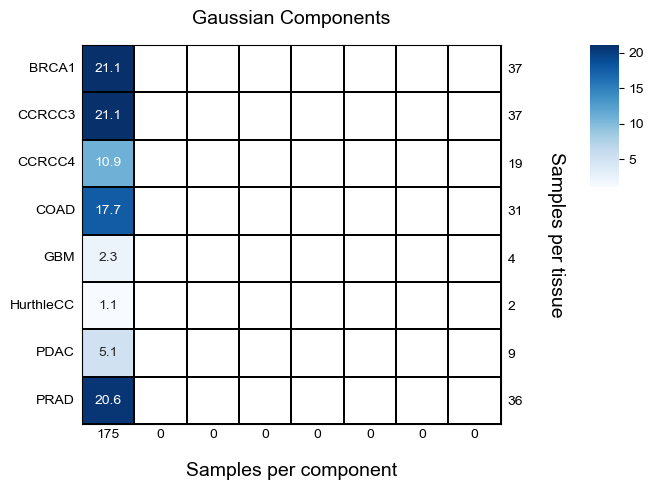

In [ ]:
cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)
# np.sum(cm, axis=0)

class_lbls = list(cohorts.keys())
# sample_num_lbls = [len(cohorts[c]['sample_list']) for c in cohorts.keys()]
sample_num_lbls = [37,37,19,31,4,2,9,36]
# plt.rcParams["font.family"] = 'sans-serif'

zr_mask = np.where(cm_norm > 0, False, True)

fig, ax = plt.subplots(figsize=(7,5))

sns.heatmap(cm_norm, cmap='Blues',
            annot=True,
            fmt='g',
            xticklabels=np.sum(cm, axis=0),
            yticklabels=class_lbls,
            linewidths=0.1,
            mask=zr_mask,
            linecolor='black',
            ax=ax,
            cbar_kws={
                'pad': 0.15,
                'shrink': 0.375,
                'aspect': 5,
                'anchor': (0.0, 1.0)
            })

ax_y = ax.twinx()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(axis='both', length=0)

ax_y.set_yticks(ax.get_yticks())
ax_y.set_ylim(ax.get_ylim())
ax_y.set_yticklabels(sample_num_lbls)
ax_y.tick_params(axis='y', length=0)

ax.set_xlabel('Samples per component', fontsize=14, labelpad=15)
ax_y.set_ylabel('Samples per tissue' , fontsize=14, labelpad=30, rotation=270)

ax.tick_params(  axis='y', direction='out', pad=5)
ax_y.tick_params(axis='y', direction='out', pad=5)

ax.set_title('Gaussian Components', pad=15, fontsize=14)

# fig.subplots_adjust(bottom=0.5)
plt.tight_layout()

### Figure X. PCA Code

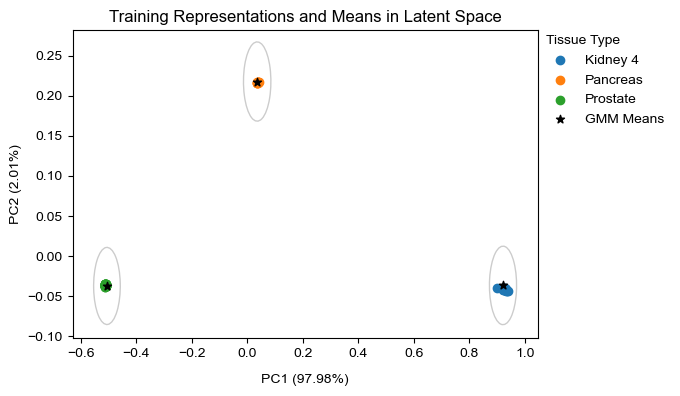

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
# import umap
means_and_reps = np.vstack((train_rep.z.detach().numpy(),dgd_final.gmm.means.detach().numpy()))
# means_and_reps = np.vstack((train_rep_final.z.detach().numpy(),dgd_final.gmm.means.detach().numpy()))
# pca = umap.UMAP(n_neighbors=2)
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(means_and_reps)
# pca_fit        = pca.fit_transform(train_rep_final.z.detach().numpy())
# pca_fit_means  = pca.transform(dgd_final.gmm.means.detach().numpy())
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]   , label='Breast'    )
ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]  , label='Colon'     )
ax.scatter(pca_fit[74:93,0]  , pca_fit[74:93,1]  , label='Kidney 3'   )
ax.scatter(pca_fit[93:124,0] , pca_fit[93:124,1] , label='Kidney 4'   )
ax.scatter(pca_fit[124:128,0], pca_fit[124:128,1], label='Brain'      )
ax.scatter(pca_fit[128:130,0], pca_fit[128:130,1], label='Thyroid')
ax.scatter(pca_fit[130:139,0], pca_fit[130:139,1], label='Pancreas'     )
ax.scatter(pca_fit[139:175,0], pca_fit[139:175,1], label='Prostate'     )
ax.scatter(pca_fit[175:,0], pca_fit[175:,1], label='GMM Means', c='black', marker='*')
# ax.scatter(pca_fit[0:19,0] , pca_fit[0:19,1] , label='Kidney 4'   )
# ax.scatter(pca_fit[19:28,0], pca_fit[19:28,1], label='Pancreas'     )
# ax.scatter(pca_fit[28:64,0], pca_fit[28:64,1], label='Prostate'     )
# ax.scatter(pca_fit[64:,0], pca_fit[64:,1], label='GMM Means', c='black', marker='*')

P = pca.components_
for x in range(0, 3):
    cov_2d = np.diag(torch.exp(dgd_final.gmm.log_var).detach().numpy()[x])
    # print(cov_2d)
    mean_2d = P @ (dgd_final.gmm.means.detach().numpy()[x] - pca.mean_)
    # mean_2d = pca_fit[175+x]
    cov_2d_projected = P @ cov_2d @ P.T

    vals, vecs = np.linalg.eigh(cov_2d_projected)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    
    std = 1.0
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean_2d, width=w, height=h, angle=angle,
                      facecolor='none', linewidth=1, edgecolor='black', alpha=0.2)
    ax.add_patch(ellipse)


# ax.scatter(pca_fit_means[:,0], pca_fit_means[:,1], label='Means', c='black'     )
ax.set_title('Training Representations and Means in Latent Space')

ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')
# ax.set_xlabel('UMAP D1')
# ax.set_ylabel('UMAP D2')
ax.legend(bbox_to_anchor=(1.30, 1.025),loc='upper right', fancybox=False, framealpha=0.0, title='Tissue Type', alignment='left')

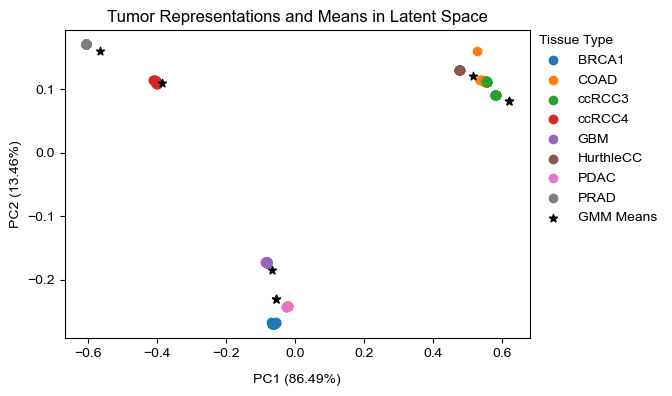

In [ ]:
pca_tumor = PCA(n_components=2)
means_and_tumor_reps = np.vstack((tumor_rep_final.detach(), dgd_final.gmm.means.detach().numpy()))
pca_fit = pca_tumor.fit_transform(means_and_tumor_reps)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pca_fit[0:61,0]  , pca_fit[0:61,1]  , label='BRCA1'     )
ax.scatter(pca_fit[61:128,0]  , pca_fit[61:128,1]  , label='COAD'     )
ax.scatter(pca_fit[128:180,0]  , pca_fit[128:180,1]  , label='ccRCC3'   )
ax.scatter(pca_fit[180:217,0] , pca_fit[180:217,1] , label='ccRCC4'   )
ax.scatter(pca_fit[217:291,0], pca_fit[217:291,1], label='GBM'      )
ax.scatter(pca_fit[291:319,0], pca_fit[291:319,1], label='HurthleCC')
ax.scatter(pca_fit[319:346,0], pca_fit[319:346,1], label='PDAC'     )
ax.scatter(pca_fit[346:437,0], pca_fit[346:437,1], label='PRAD'     )
ax.scatter(pca_fit[437:,0], pca_fit[437:,1], label='GMM Means', c='black', marker='*')
ax.set_title('Tumor Representations and Means in Latent Space')

ax.set_xlabel(f'PC1 ({(pca_tumor.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
ax.set_ylabel(f'PC2 ({(pca_tumor.explained_variance_ratio_[1] * 100):.2f}%)')
ax.legend(bbox_to_anchor=(1.30, 1.025),loc='upper right', fancybox=False, framealpha=0.0, title='Tissue Type', alignment='left')

### Figure X. Tumor Matrix

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
le = LabelEncoder()
true_labels = le.fit_transform(df_tumor_lbls[0:61])
clustering  = torch.exp(dgd_model.gmm.get_log_prob_comp(rep_final.detach()))
pred_labels = torch.max(clustering, dim=-1).indices.cpu().detach()
cm_tumor = confusion_matrix(true_labels, pred_labels)

In [ ]:
# cm_norm = np.round(np.nan_to_num(cm / np.sum(cm, axis=0) * 100), decimals=1)
# np.sum(cm, axis=0)

class_lbls = list(cohorts.keys())
# sample_num_lbls = [len(cohorts[c]['sample_list']) for c in cohorts.keys()]
plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.family"] = 'sans-serif'

zr_mask = np.where(cm_tumor > 0, False, True)

fig, ax = plt.subplots(figsize=(7,5))

sns.heatmap(cm_tumor, cmap='Blues',
            annot=True,
            fmt='g',
            xticklabels=class_lbls,
            yticklabels=class_lbls,
            linewidths=0.1,
            mask=zr_mask,
            linecolor='black',
            ax=ax,
            cbar_kws={
                'pad': 0.15,
                'shrink': 0.375,
                'aspect': 5,
                'anchor': (0.0, 1.0)
            })

# ax_y = ax.twinx()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(axis='both', length=0)

# ax_y.set_yticks(ax.get_yticks())
# ax_y.set_ylim(ax.get_ylim())
# ax_y.set_yticklabels(class_lbls)
# ax_y.tick_params(axis='y', length=0)

ax.set_xlabel('GMM Components', fontsize=14, labelpad=15)
# ax_y.set_ylabel('Samples per tissue' , fontsize=14, labelpad=30, rotation=270)

ax.tick_params(  axis='y', direction='out', pad=5)
# ax_y.tick_params(axis='y', direction='out', pad=5)

ax.set_title('Gaussian Components', pad=15, fontsize=14)

# fig.subplots_adjust(bottom=0.5)
plt.tight_layout()

In [ ]:
# pca_rep_final = PCA(n_components=2)
import umap
um = umap.UMAP(random_state=100)

rep_final_res = um.fit_transform(rep_final.detach().numpy())
iter_list = [(0, 61, 'BRCA1'), (61, 128, 'ccRCC3'),
             (128, 180, 'ccRCC4'), (180, 217, 'COAD'),
             (217, 291, 'GBM'), (291, 319, 'HurthleCC'),
             (319, 346, 'PDAC'), (346, 437, 'PRAD')]
for i,j, lbl in iter_list:
    plt.scatter(rep_final_res[i:j,0], rep_final_res[i:j, 1], label=lbl)
# plt.legend()

# OTHER CODE

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_log.to_numpy())
for (i,j) in [(0,47), (47,94), (94,118), (118,157), (157,163), (163,166), (166,178), (178,224)]:
    print(np.var(pca_fit[i:j], axis=0))

In [ ]:
# import matplotlib.pyplot as plt
# import umap
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# pca_fit = pca_test.fit_transform(df_log.to_numpy())
# pca_fit = pca.fit_transform(np.exp2(df.T.to_numpy()[:,:-1].astype(np.float64)))
pca_fit = pca.fit_transform(train_rep.z.detach().numpy())
# pca_fit = pca.fit_transform(test_rep.z.detach().numpy())

# um = umap.UMAP(random_state=100)
# pca_fit = um.fit_transform(df.T.to_numpy()[:, :-1])
# pca_fit = um.fit_transform(df_exp_smote.to_numpy())
fig, ax = plt.subplots(figsize=(6,4))
### ALL 
# pca_fit = um.fit_transform(df_log.to_numpy())
# ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    )
# ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     )
# ax.scatter(pca_fit[94:118,0]  , pca_fit[94:118,1]  , label='ccRCC3' )
# ax.scatter(pca_fit[118:157,0] , pca_fit[118:157,1] , label='ccRCC4' )
# ax.scatter(pca_fit[157:163,0], pca_fit[157:163,1], label='GBM'      )
# ax.scatter(pca_fit[163:166,0], pca_fit[163:166,1], label='HurthleCC')
# ax.scatter(pca_fit[166:178,0], pca_fit[166:178,1], label='PDAC'     )
# ax.scatter(pca_fit[178:224,0], pca_fit[178:224,1], label='PRAD'     )
# ax.set_title('PCA - ALL')

### TRAIN_REP
# pca_fit = um.fit_transform(train_rep.z.detach().numpy())
ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]   , label='BRCA1'    )
ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]  , label='COAD'     )
ax.scatter(pca_fit[74:93,0]  , pca_fit[74:93,1]  , label='ccRCC3'   )
ax.scatter(pca_fit[93:124,0] , pca_fit[93:124,1] , label='ccRCC4'   )
ax.scatter(pca_fit[124:128,0], pca_fit[124:128,1], label='GBM'      )
ax.scatter(pca_fit[128:130,0], pca_fit[128:130,1], label='HurthleCC')
ax.scatter(pca_fit[130:139,0], pca_fit[130:139,1], label='PDAC'     )
ax.scatter(pca_fit[139:175,0], pca_fit[139:175,1], label='PRAD'     )
ax.set_title('PCA - TRAIN_REP')

### TEST_REP
# pca_fit = um.fit_transform(test_rep.z.detach().numpy())
# ax.scatter(pca_fit[0:10,0]   , pca_fit[0:10,1]   , label='BRCA1' )
# ax.scatter(pca_fit[10:20,0]  , pca_fit[10:20,1]  , label='COAD'  )
# ax.scatter(pca_fit[20:25,0]  , pca_fit[20:25,1]  , label='ccRCC3')
# ax.scatter(pca_fit[25:33,0] , pca_fit[25:33,1] , label='ccRCC4'  )
# ax.scatter(pca_fit[33:35,0], pca_fit[33:35,1], label='GBM'       )
# ax.scatter(pca_fit[35:36,0], pca_fit[35:36,1], label='HurthleCC' )
# ax.scatter(pca_fit[36:39,0], pca_fit[36:39,1], label='PDAC'      )
# ax.scatter(pca_fit[39:49,0], pca_fit[39:49,1], label='PRAD'      )
# ax.set_title('PCA - TEST_REP')


### SMOTE - TEST_REP
# ax.scatter(pca_fit[0:10,0]   , pca_fit[0:10,1]   , label='BRCA1' )
# ax.scatter(pca_fit[10:20,0]  , pca_fit[10:20,1]  , label='COAD'  )
# ax.scatter(pca_fit[20:30,0]  , pca_fit[20:30,1]  , label='ccRCC3')
# ax.scatter(pca_fit[30:40,0] , pca_fit[30:40,1] , label='ccRCC4'  )
# ax.scatter(pca_fit[40:50,0], pca_fit[40:50,1], label='GBM'       )
# ax.scatter(pca_fit[50:222,0], pca_fit[50:60,1], label='HurthleCC')
# ax.scatter(pca_fit[60:70,0], pca_fit[60:70,1], label='PDAC'      )
# ax.scatter(pca_fit[70:80,0], pca_fit[70:80,1], label='PRAD'      )

### SMOTE - TRAIN_REP
# ax.scatter(pca_fit[0:37,0]   , pca_fit[0:37,1]     , label='BRCA1'    )
# ax.scatter(pca_fit[37:74,0]  , pca_fit[37:74,1]    , label='COAD'     )
# ax.scatter(pca_fit[74:111,0]  , pca_fit[74:111,1]  , label='ccRCC3'   )
# ax.scatter(pca_fit[111:148,0] , pca_fit[111:148,1] , label='ccRCC4'   )
# ax.scatter(pca_fit[148:185,0], pca_fit[148:185,1]  , label='GBM'      )
# ax.scatter(pca_fit[185:222,0], pca_fit[185:222,1]  , label='HurthleCC')
# ax.scatter(pca_fit[222:259,0], pca_fit[222:259,1]  , label='PDAC'     )
# ax.scatter(pca_fit[259:296,0], pca_fit[259:296,1]  , label='PRAD'     )

### SMOTE - ALL
# ax.scatter(pca_fit[0:47,0]   , pca_fit[0:47,1]   , label='BRCA1'    )
# ax.scatter(pca_fit[47:94,0]  , pca_fit[47:94,1]  , label='COAD'     )
# ax.scatter(pca_fit[94:141,0]  , pca_fit[94:141,1]  , label='ccRCC3' )
# ax.scatter(pca_fit[141:188,0] , pca_fit[141:188,1] , label='ccRCC4' )
# ax.scatter(pca_fit[188:235,0], pca_fit[188:235,1], label='GBM'      )
# ax.scatter(pca_fit[235:282,0], pca_fit[235:282,1], label='HurthleCC')
# ax.scatter(pca_fit[282:329,0], pca_fit[282:329,1], label='PDAC'     )
# ax.scatter(pca_fit[329:376,0], pca_fit[329:376,1], label='PRAD'     )


# ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
# ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')
# ax.set_xlabel('UMAP D1')
# ax.set_ylabel('UMAP D2')
ax.legend(bbox_to_anchor=(1.275, 1),loc='upper right', fancybox=False, framealpha=0.0)

## WITH SMOTE

In [ ]:
# ## Apply SMOTE so all classes are of size 47
# sm = SMOTE(random_state=100, k_neighbors=2)
# np_log_smote, df_lbls_smote = sm.fit_resample(df_log.to_numpy(), np.array(df_lbls))

# ## Update the sample_list for data loaders later
# complete_list = []
# for c in cohorts:
#     sample_list = cohorts[c]['sample_list']

#     if len(sample_list) < 47:
#         smote_sample_list = [c + '_' + str(x+1) for x in range(len(sample_list), 47)]
#         cohorts[c]['sample_list'] += smote_sample_list
#     complete_list += cohorts[c]['sample_list']
        
# df_log_smote = pd.DataFrame(np_log_smote, index=complete_list, columns=df_log.columns.to_list())

In [ ]:
# sb_prior_sample = dgd_model.gmm.means_prior['dist'].sample(10000)
# log_prob = dgd_model.gmm.means_prior['dist'].log_prob(sb_prior_sample).numpy()
# true_prob = np.exp(log_prob)
# plt.hist(log_prob, bins=50, density=True, edgecolor='black')
# plt.hist(sb_prior_sample[:,0], bins=50, density=True, edgecolor='black')
# plt.hist(sb_prior_sample[:,1], bins=50, density=True, edgecolor='black')
# plt.hist2d(sb_prior_sample[:,0], sb_prior_sample[:,1], bins=50)
# plt.show()

In [ ]:
from sklearn.decomposition import PCA
# test_cohorts = cohorts.copy()
X = df_exp.to_numpy()
y = np.array(df_lbls)

sm = SMOTE(random_state=100, k_neighbors=2)
X_new, y_new = sm.fit_resample(X, y)


pca = PCA(n_components=2)
res = pca.fit_transform(X_new)

sum = 0
colors = {
    'BRCA1': 'red',
    'ccRCC3': 'orange',
    'ccRCC4': 'yellow',
    'COAD': 'green',
    'GBM': 'blue',
    'HurthleCC': 'purple',
    'PDAC': 'brown',
    'PRAD': 'black',
}

for i in np.unique(y_new).tolist():
    plt.scatter(res[sum:sum+47, 0], res[sum:sum+47, 1], c=colors[i])
    sum += 47

plt.xlabel(pca.explained_variance_ratio_[0] * 100)
plt.ylabel(pca.explained_variance_ratio_[1] * 100)
plt.title("PCA after SMOTE")

## E. Hyperparameter Grid Search

In [ ]:
import wandb

def grid_search(config=None):
    with wandb.init(config=config):
        c = wandb.config

        dgd_cand = model.MetaboDGD(
            latent_dim=c.latent_dim,
            output_dim=df_log.shape[1],
            dec_hidden_layers_dim=[500, 1500],
            dec_output_prediction_type='mean',
            dec_output_activation_type='softplus',
            n_comp=8,
            cm_type='diagonal',
            softball_radius=c.softball_radius,
            softball_sharpness=c.softball_sharpness,
            gaussian_mean=c.gaussian_mean,
            gaussian_stddev=c.gaussian_stddev,
            dirichlet_alpha=c.dirichlet_alpha
        )

        dgd_cand, train_rep, test_rep, history, cm = train.train_dgd(
            dgd_model=dgd_cand,
            train_loader=train_loader,
            validation_loader=test_loader,
            n_epochs=250,
            lr_schedule_epochs=None,
            lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
            optim_betas=[0.5, 0.7],
            wd=1e-5,
        )

        wandb.log({"validation_reconstruction_loss": history.iloc[-1]['val_loss'],
                   "cluster_acc": history.iloc[-1]['cluster_acc']})


def execute_grid_search():
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'cluster_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'latent_dim': {
                'values': [20, 30],
            },
            'dirichlet_alpha': {
                'values': [0.5, 1.0],
            },
            'softball_radius': {
                'values': [3, 5, 7],
            },
            'softball_sharpness': {
                'values': [5, 10],
            },
            'gaussian_mean': {
                'values': [-6.0, -5.0],
            },
            'gaussian_stddev': {
                'values': [0.01, 0.25, 0.50]
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep=sweep_config,
        project="my-first-project"
    )

    wandb.agent(
        sweep_id=sweep_id,
        function=grid_search
    )


# execute_grid_search()